In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"



In [45]:
from functools import partial

import jax
import jax.numpy as jnp
import jax_galsim as xgalsim
import matplotlib.pyplot as plt 

from jax import random
from jax import vmap, grad, jit

import numpy as np

import galsim

import matplotlib.pyplot as plt



In [6]:
@jax.jit
def render_bd(
    lf, scale_radius, q, beta, x, y, *, psf_hlr=0.7, slen=53, fft_size=256, pixel_scale=0.2
):
    gsparams = xgalsim.GSParams(minimum_fft_size=fft_size, maximum_fft_size=fft_size)

    bulge = xgalsim.Spergel(nu=-0.6, flux=10**lf, scale_radius=scale_radius).shear(
        q=q,
        beta=beta * xgalsim.radians,
    )

    psf = xgalsim.Gaussian(flux=1.0, half_light_radius=0.7)
    gal_conv = xgalsim.Convolve([bulge, psf]).withGSParams(gsparams)
    galaxy_image = gal_conv.drawImage(nx=slen, ny=slen, scale=pixel_scale, offset=(x,y)).array
    return galaxy_image

In [39]:
def render_bd_galsim(
    lf, scale_radius, q, beta, x, y, *, psf_hlr=0.7, slen=53, fft_size=256, pixel_scale=0.2
):

    bulge = galsim.Spergel(nu=-0.6, flux=10**lf, scale_radius=scale_radius).shear(
        q=q,
        beta=beta * galsim.radians,
    )

    psf = galsim.Gaussian(flux=1.0, half_light_radius=0.7)
    gal_conv = galsim.Convolve([bulge, psf])
    galaxy_image = gal_conv.drawImage(nx=slen, ny=slen, scale=pixel_scale, offset=(x,y)).array
    return galaxy_image

In [35]:
# image size? 
bulge = galsim.Spergel(nu=-0.6, flux=10**5, scale_radius=0.7).shear(
    q=0.2,
    beta=np.pi/2 * galsim.radians,
)

psf = galsim.Gaussian(flux=1.0, half_light_radius=0.7)
gal_conv = galsim.Convolve([bulge, psf])
gal_conv.getGoodImageSize(0.2)

66

In [36]:
image  = render_bd(5.0, 0.7, 0.2, jnp.pi / 2, 0.0, 0.0) # compile

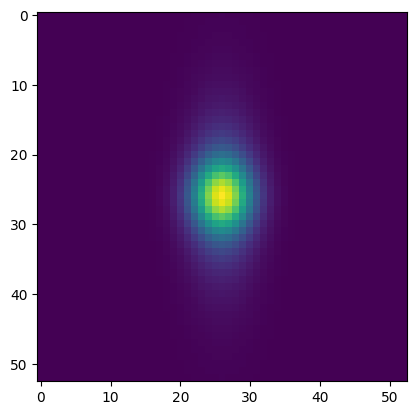

In [37]:
plt.imshow(image)

In [17]:
# timing
%timeit _ = render_bd(5.0, 1.0, 0.2, jnp.pi / 2, 0.0, 0.0)

210 μs ± 2.42 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [41]:
%timeit _ = render_bd_galsim(5.0, 1.0, 0.2, jnp.pi / 2, 0.0, 0.0)

413 μs ± 18.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
from bpd.draw import draw_gaussian


draw_gaussian_jitted = jax.jit(partial(draw_gaussian, slen=53, fft_size=252))
_ = draw_gaussian_jitted(f=1e6, hlr=1.0, e1=0.2, e2=0.2, g1=0.02, g2=0.0,x=0,y=0)

In [51]:
# compare with Gaussian
%timeit _ = draw_gaussian_jitted(f=1e6, hlr=1.0, e1=0.2, e2=0.2, g1=0.02, g2=0.0,x=0,y=0)

241 μs ± 1.38 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [53]:
# check good size of Gaussian to see how much it matters
gal = galsim.Gaussian(flux=1e5, half_light_radius=2.0)
psf = galsim.Gaussian(flux=1.0, half_light_radius=0.7)
gal_conv = galsim.Convolve([gal, psf])
gal_conv.getGoodImageSize(0.2)

106